In [1]:
%cd ..

/Users/w1ufxk2/Desktop/hotel_cancellation_forecasting/src


In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
pdf = pd.read_csv("data/processed_bookings.csv", sep=";")
pdf.head()

,Unnamed: 0,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,...,repeated,P-C,P-not-C,average price,special requests,booking status,date,day,month,year
0,0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,...,0,0,0,88.00,0,0,2015-10-02,2,10,2015
1,1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,...,0,0,0,106.68,1,0,2018-11-06,6,11,2018
2,2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,...,0,0,0,50.00,0,1,2018-02-28,28,2,2018
3,3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,...,0,0,0,100.00,1,1,2017-05-20,20,5,2017
4,4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,...,0,0,0,77.00,0,1,2018-04-11,11,4,2018


In [4]:
numerical_features = ["number of children", "number of weekend nights", "number of week nights", "lead time", "average price"]

categorical_features = ["type of meal", "car parking space", "room type", "market segment type", "special requests", "day", "month"]

target = ["booking status"]

pdf = pdf[categorical_features + numerical_features + target]

pdf.head()

,type of meal,car parking space,room type,market segment type,special requests,day,month,number of children,number of weekend nights,number of week nights,lead time,average price,booking status
0,Meal Plan 1,0,Room_Type 1,Offline,0,2,10,1,2,5,224,88.00,0
1,Not Selected,0,Room_Type 1,Online,1,6,11,0,1,3,5,106.68,0
2,Meal Plan 1,0,Room_Type 1,Online,0,28,2,1,1,3,1,50.00,1
3,Meal Plan 1,0,Room_Type 1,Online,1,20,5,0,0,2,211,100.00,1
4,Not Selected,0,Room_Type 1,Online,0,11,4,0,1,2,48,77.00,1


In [5]:
# Scale numericals so they are on the same level and none of them gets more weight because of scaling
scaler = MinMaxScaler()

pdf_scaled = pd.DataFrame(scaler.fit_transform(pdf[numerical_features]), columns = numerical_features)

# Join back to pdf 
pdf_numericals_scaled = pd.concat((pdf.drop(numerical_features, axis=1), pdf_scaled), axis=1)

pdf_numericals_scaled.head()

,type of meal,car parking space,room type,market segment type,special requests,day,month,booking status,number of children,number of weekend nights,number of week nights,lead time,average price
0,Meal Plan 1,0,Room_Type 1,Offline,0,2,10,0,0.1,0.285714,0.294118,0.505643,0.162963
1,Not Selected,0,Room_Type 1,Online,1,6,11,0,0.0,0.142857,0.176471,0.011287,0.197556
2,Meal Plan 1,0,Room_Type 1,Online,0,28,2,1,0.1,0.142857,0.176471,0.002257,0.092593
3,Meal Plan 1,0,Room_Type 1,Online,1,20,5,1,0.0,0.000000,0.117647,0.476298,0.185185
4,Not Selected,0,Room_Type 1,Online,0,11,4,1,0.0,0.142857,0.117647,0.108352,0.142593


In [6]:
# Make sure data types are as they should be
print(pdf_numericals_scaled.dtypes)

type of meal                 object
car parking space             int64
room type                    object
market segment type          object
special requests              int64
day                           int64
month                         int64
booking status                int64
number of children          float64
number of weekend nights    float64
number of week nights       float64
lead time                   float64
average price               float64
dtype: object


In [7]:
# Create dummies of categorical features & drop first
pdf_with_dummies = pd.get_dummies(pdf_numericals_scaled, drop_first=True, columns=categorical_features, dtype=int)
pdf_with_dummies.head()

,booking status,number of children,number of weekend nights,number of week nights,lead time,average price,type of meal_Meal Plan 2,type of meal_Meal Plan 3,type of meal_Not Selected,car parking space_1,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0,0.1,0.285714,0.294118,0.505643,0.162963,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0.0,0.142857,0.176471,0.011287,0.197556,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0.1,0.142857,0.176471,0.002257,0.092593,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0.0,0.000000,0.117647,0.476298,0.185185,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,0.0,0.142857,0.117647,0.108352,0.142593,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [8]:
X = pdf_with_dummies.drop(target, axis=1)
y = pdf_with_dummies[target]

In [9]:
X

,number of children,number of weekend nights,number of week nights,lead time,average price,type of meal_Meal Plan 2,type of meal_Meal Plan 3,type of meal_Not Selected,car parking space_1,room type_Room_Type 2,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0.1,0.285714,0.294118,0.505643,0.162963,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.0,0.142857,0.176471,0.011287,0.197556,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.1,0.142857,0.176471,0.002257,0.092593,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.000000,0.117647,0.476298,0.185185,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0.0,0.142857,0.117647,0.108352,0.142593,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36243,0.0,0.000000,0.117647,0.781038,0.212963,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
36244,0.0,0.142857,0.176471,0.076749,0.199167,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
36245,0.0,0.142857,0.176471,0.187359,0.195574,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
36246,0.0,0.000000,0.235294,0.273138,0.179444,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [10]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [11]:
# Check for overfitting first (this could also be done in a small dataset and not the full X_train dataset)
model = LogisticRegression()

scores = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc")
print(f"Cross validation AUC-ROC scores: {scores}")

scores = pd.Series(scores)
print(f"Minimum score = {scores.min()} \n"
      f"Average score = {scores.mean()} \n"
      f"Maximum score = {scores.max()})")

# The results show that the AUC-ROC score is quite stable across the 5 folds. Therefore overfitting is not an issue at the moment.


Cross validation AUC-ROC scores: [0.87130061 0.87525747 0.87254947 0.87813295 0.8692551 ]
Minimum score = 0.8692550984917353 
Average score = 0.8732991200027292 
Maximum score = 0.8781329540612949)


In [12]:
# Fit a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)
predictions_array = model.predict(X_test)

# join X_test to predictions_array to get the actual predictions
X_test_with_predictions = pd.DataFrame(predictions_array, columns=["y hat"], index=X_test.index)
X_test_with_predictions = pd.concat((X_test, X_test_with_predictions), axis=1)
X_test_with_predictions.head()


,number of children,number of weekend nights,number of week nights,lead time,average price,type of meal_Meal Plan 2,type of meal_Meal Plan 3,type of meal_Not Selected,car parking space_1,room type_Room_Type 2,...,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,y hat
18119,0.0,0.285714,0.058824,0.182844,0.191667,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
29389,0.0,0.000000,0.117647,0.279910,0.180648,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
10098,0.0,0.000000,0.117647,0.069977,0.251667,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
14170,0.0,0.142857,0.058824,0.011287,0.250926,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
29413,0.0,0.000000,0.176471,0.153499,0.132093,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [13]:
accuracy = accuracy_score(y_test, predictions_array)
print(f"Accuracy: {accuracy}")

# Predict probabilities for avaiability = 1
y_pred_prob = model.predict_proba(X)[:, 1]

#TODO: check if ytest and y pred should be seperated and if they are the correct inputs
# AUC-ROC score: quantifies the model's ability to distinguish between the positive and negative classes
roc_auc = roc_auc_score(y, y_pred_prob)

print(f"AUC-ROC Score: {roc_auc}")

Accuracy: 0.8057931034482758
AUC-ROC Score: 0.8741014805040062


In [14]:
probabilities_array = model.predict_proba(X_test)
probabilities_array

# probabilities = pd.DataFrame(probabilities_array, columns = ["probabilities_0", "probabilities_1"])

array([[0.70284139, 0.29715861],
       [0.28077682, 0.71922318],
       [0.92193171, 0.07806829],
       ...,
       [0.93689778, 0.06310222],
       [0.88715804, 0.11284196],
       [0.93149276, 0.06850724]])

In [15]:
# Join predictions to x_test
predictions = pd.DataFrame(predictions_array, columns = ["predictions"])
X_test = X_test.reset_index()
output = pd.concat([X_test, predictions], axis=1)


In [16]:
output

,index,number of children,number of weekend nights,number of week nights,lead time,average price,type of meal_Meal Plan 2,type of meal_Meal Plan 3,type of meal_Not Selected,car parking space_1,...,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,predictions
0,18119,0.0,0.285714,0.058824,0.182844,0.191667,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,29389,0.0,0.000000,0.117647,0.279910,0.180648,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,10098,0.0,0.000000,0.117647,0.069977,0.251667,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,14170,0.0,0.142857,0.058824,0.011287,0.250926,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,29413,0.0,0.000000,0.176471,0.153499,0.132093,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7245,25536,0.0,0.000000,0.235294,0.207675,0.165278,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7246,20383,0.0,0.285714,0.058824,0.214447,0.141667,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
7247,23169,0.0,0.000000,0.176471,0.081264,0.168519,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7248,5665,0.0,0.000000,0.176471,0.099323,0.138889,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
coef = model.coef_[0]

feature_importance = pd.DataFrame({"feature": X.columns, "coef": coef})

feature_importance["abs_coef"] = abs(feature_importance["coef"])

feature_importance = feature_importance.sort_values(by="abs_coef", ascending=False)


In [18]:
feature_importance.head(20)

,feature,coef,abs_coef
4,average price,9.762627,9.762627
3,lead time,7.291734,7.291734
21,special requests_3,-5.730631,5.730631
22,special requests_4,-3.776623,3.776623
20,special requests_2,-2.589254,2.589254
54,month_2,2.179035,2.179035
15,market segment type_Complementary,-2.140624,2.140624
55,month_3,1.984610,1.984610
63,month_11,1.939144,1.939144
56,month_4,1.750947,1.750947


<Figure size 1000x600 with 0 Axes>

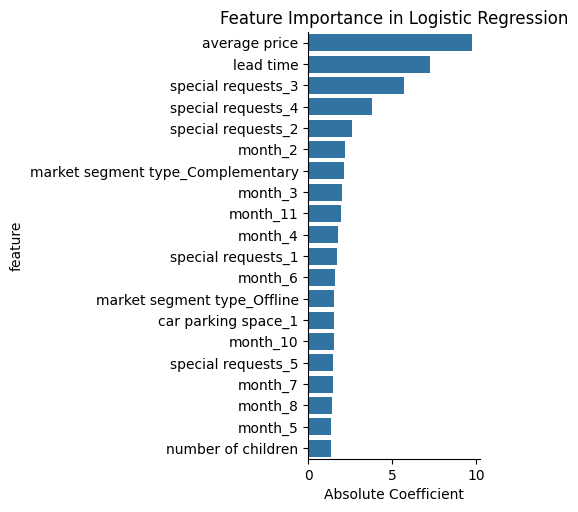

In [19]:
plt.figure(figsize=(10, 6))

sns.catplot(x = "abs_coef", y = "feature", data = feature_importance.head(20), kind = "bar", orient="h")

plt.xlabel("Absolute Coefficient")
plt.title("Feature Importance in Logistic Regression")
plt.show()


### Compare to null accuracy

In [21]:
# We need to compare the created model to the null accuracy, so as to determine whether the model is good enough
# Null accuracy: accuracy that could be achieved by always predicting the most frequent class
y_test.value_counts()

# in our case, the most frequent class is 0, Not Cancelled
# the null accuracy is calculated by dividing the number of observations with the most frequent class by the total number of observations


booking status
0                 4881
1                 2369
Name: count, dtype: int64

In [29]:
null_accuracy = (4881/ (4881 + 2369)) * 100
accuracy = accuracy *100

print(f"Null accuracy - baseline model is {null_accuracy:.2f} %")
print(f"Accuracy with current model is {accuracy:.2f} %")

if accuracy > null_accuracy:
    print("The model looks to be better than the baseline")
else:
    print("Looks like the model has not improved the baseline")

Null accuracy - baseline model is 67.32 %
Accuracy with current model is 80.58 %
The model is better than the baseline
